# Using an IMERG Event to Subset SSMIS/ATMS data from STARE-PODS

Michael Lee Rilee, mike@bayesics.com

First version: 2022-0529

In [1]:
import sys
sys.path.insert(0,'/homelocal/mrilee/git/pystareplotlib')

import os
os.environ['PROJ_LIB'] = '/homelocal/mrilee/opt/anaconda3/envs/stare-1/share/proj'

import pystare
import starepandas
import geopandas

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs

import pystareplotlib
import pystareplotlib.pystareplotlib as psplot

import numpy
import pandas

import pickle
import datetime

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

plot_options['projection']._threshold = 0.001;

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Some helper functions

def mnmx(x):
    return min(x),max(x)
def span(x):
    return max(x)-min(x)

class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

In [4]:
start00 = datetime.datetime.now()

In [5]:
data_dir = '/tablespace/xcal/'
with open(f'{data_dir}/pickles/featuredb.pickle', 'rb') as f:
    features = pickle.load( f)

In [6]:
timings.add('Load features',datetime.datetime.now()-start00)
start01=datetime.datetime.now()

Load features 0:00:16.144025


# Load US States and establish Region of Interest (ROI)

In [7]:
states = geopandas.read_file('ignored/tl_2019_us_state.zip')

In [8]:
states = starepandas.STAREDataFrame(states)
sids = states.make_sids(n_partitions=50, level=10)
states.set_sids(sids, inplace=True)
trixels = states.make_trixels(n_partitions=50, wrap_lon=False)
states.set_trixels(trixels, inplace=True)
states.split_antimeridian(inplace=True)

In [9]:
roi_name = 'Virginia'
roi = states[states['NAME']==roi_name]
roi_sids = roi.sids.iloc[0]

In [10]:
timings.add('Construct ROI STARE cover',datetime.datetime.now()-start01)
start02=datetime.datetime.now()

Construct ROI STARE cover 0:00:57.074721


# Pull out events intersecting the ROI

In [11]:
intersects = features.stare_intersects(roi_sids, n_partitions=60) 
features[intersects].label.unique()

array([17, 65, 79, 91, 94], dtype=int32)

In [12]:
# Select off the first event
event_17 = features[features.label==17]

In [13]:
# Construct cover and trixels for visualizing the event
dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])

trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

In [14]:
timings.add('Select features intersecting ROI.',datetime.datetime.now()-start02)
start03=datetime.datetime.now()

Select features intersecting ROI. 0:00:12.163131


# Calculating precip 

## Precip for the whole event

In [15]:
tot_precip = event_17.tot_precip.sum()
print(f'Total Precip: {tot_precip:,.2f} cubic meters')

Total Precip: 61,980,755,210.15 cubic meters


## Getting timeframes of the event that intersected roi

In [16]:
intersects = event_17.stare_intersects(roi_sids)
over_roi = event_17.reset_index()[intersects]

## Getting the cells/sids/trixels that intersect roi

In [17]:
over_roi['in'] =  over_roi['sids'].apply(lambda row: pystare.intersects(roi_sids, row))

## Calculating Total Precip over roi

In [18]:
def calc_tot_precip(row):
    return (row['cell_areas']*row['precips']/1000/2*row['in']).sum()
    
over_roi['precip_in_roi'] = over_roi.apply(lambda row: calc_tot_precip(row), axis=1)

In [19]:
roi_precip = over_roi['precip_in_roi'].sum()
roi_precip_share = roi_precip/tot_precip * 100
print(f'Share of event 17 in roi is {roi_precip_share:2.2f} %')

dt_hr = (event_17.timestamp.max()-event_17.timestamp.min()).total_seconds()/3600.0 # over estimate
roi_area_m2=(roi.ALAND+roi.AWATER)
roi_precip_mm_per_m2 = 1000.0*roi_precip/roi_area_m2
print(f'Total precip in roi is {roi_precip_mm_per_m2.iloc[0]:4.1f} mm/m^2')
print(f'Precip rate in roi is {roi_precip_mm_per_m2.iloc[0]/dt_hr:4.1f} mm/(m^2 hr) -- lower bound')
# print(f'Precip in roi is {roi_precip_mm_per_m2.iloc[0]:4.1f} kg/m^2')

Share of event 17 in roi is 7.89 %
Total precip in roi is 44.2 mm/m^2
Precip rate in roi is  0.7 mm/(m^2 hr) -- lower bound


# Total Runtime

In [20]:
timings.add('Precip rate analysis',datetime.datetime.now()-start03)
timings.add('Total run time for IMERG statistics associated with ROI',datetime.datetime.now()-start00)

Precip rate analysis 0:00:00.433059
Total run time for IMERG statistics associated with ROI 0:01:25.815338


## Event Duration

In [21]:
# Duration
event_17.timestamp.max()-event_17.timestamp.min()

Timedelta('2 days 12:30:00')

In [22]:
# Start and stop times of the event
event_17.timestamp.min(),event_17.timestamp.max()

(Timestamp('2021-01-24 20:30:00'), Timestamp('2021-01-27 09:00:00'))

In [23]:
# Time over the ROI
over_roi.timestamp.max()-over_roi.timestamp.min()

Timedelta('1 days 04:30:00')

In [24]:
# Entrance and exit time of the event over the ROI
over_roi.timestamp.min(),over_roi.timestamp.max()

(Timestamp('2021-01-25 09:00:00'), Timestamp('2021-01-26 13:30:00'))

In [25]:
# Make a timestamp for timing performance
start04=datetime.datetime.now()

## Visualize the cumulative event and several timeslices over the ROI.

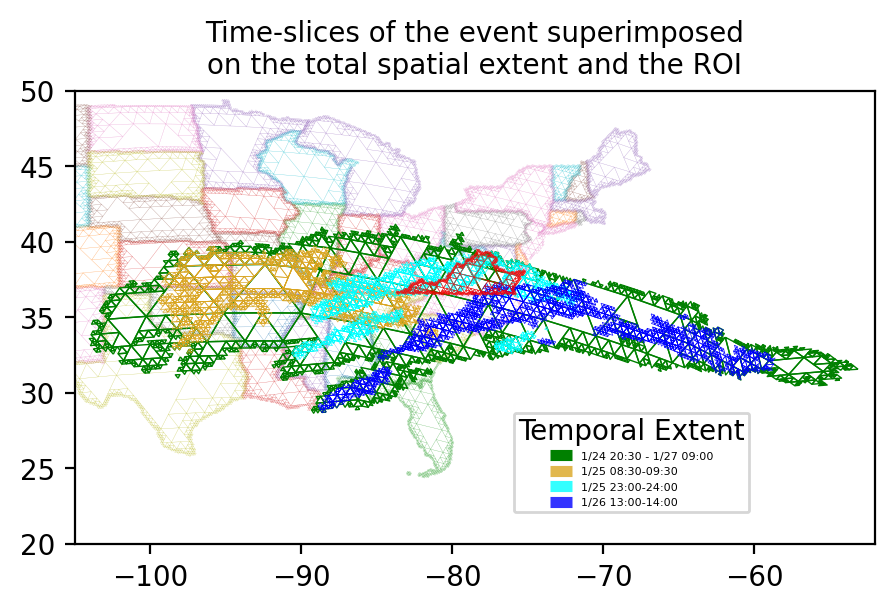

In [26]:
fig = plt.figure(figsize=(6, 3), dpi=200)
ax = fig.add_subplot()

ax.set_xlim(-105, -65+13)
ax.set_ylim(20, 50)

states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])

trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='g', label='1/24 20:30 - 1/27 09:00')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-25 08:30:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-25 09:30:00')))]
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='goldenrod',alpha=0.8,label='1/25 08:30-09:30')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-25 23:00:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-26 00:00:00')))]
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='cyan',alpha=0.8,label='1/25 23:00-24:00')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-26 13:00:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-26 14:00:00')))]
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='b',alpha=0.8,label='1/26 13:00-14:00')

# event_17.plot(ax=ax, zorder=1, linewidth=0.1)

roi.plot(ax=ax, zorder=4, color='r', linewidth=0.2,alpha=0.7)

leg = plt.legend(bbox_to_anchor=(0.85,0.3),markerscale=20,title='Temporal Extent',prop={'size': 4})
for l in leg.get_lines():
    l.set_linewidth(4)

# plt.suptitle('The Event Moving through Virginia',fontsize=12)
plt.title('Time-slices of the event superimposed\non the total spatial extent and the ROI',fontsize=10)
plt.show()

del fig,ax

In [27]:
timings.add('Time-slices visualization',datetime.datetime.now()-start04)
start05=datetime.datetime.now()

Time-slices visualization 0:00:08.515385


In [28]:
# Take advantage of the fact that the resolution is all finer than 4 and 4 is the size of the pods.
# print(mnmx(dissolved_event.sids.values[0] & 31 ))

# Get the STARE cover for the cumulative (total) spatial extent of the event
dissolved_event_sids=starepandas.STAREDataFrame(sids=numpy.unique(pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(dissolved_event.sids.values[0],4)))).hex()

In [29]:
# Get the names indicating which spatial pods to search for chunks
b = numpy.unique(pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(dissolved_event.sids.values[0],4)))

In [30]:
timings.add('Calculate pod names',datetime.datetime.now()-start05)

Calculate pod names 0:00:00.015235


## Set the regex pattern for the pods to subset

In [31]:
# The current prototype STARE-PODS uses only STARE/HTM (spatial) indexing, not temporal
# pattern='S1.1C.F16.*2021012[4567].*' # Restrict to F16
# pattern='S1.1C.F16.*20210124.*' # Restrict to F16 on the 24th
pattern='S1\.1C..*\.2021012[4567].*'

## Set the STARE region to read from pods

In [32]:
start06=datetime.datetime.now()

In [33]:
# sids_=['0x2220000000000004'] # Select one pod

# Load all of the data from the event, inject the cover of the entire event
sids_=dissolved_event_sids

In [34]:
s1 = starepandas.read_pods(pod_root='/tablespace/xcal/starepods/', sids=sids_, pattern=pattern, add_podname=True)

In [35]:
timings.add('XCAL initial load',datetime.datetime.now()-start06)
start07a=datetime.datetime.now()

XCAL initial load 0:00:20.995567


In [36]:
# Which instrument platforms are we using?
print('{:8} {}'.format('Platform','IFOVs loaded'))
print('-------- ------------')
for k in ['F16','F17','F18','NOAA20','NPP']:
    print('{:8} {}'.format(k,s1[s1.pod.str.contains(k)].size))

Platform IFOVs loaded
-------- ------------
F16      1515288
F17      1537400
F18      1518640
NOAA20   1129296
NPP      1152384


In [37]:
# Tell starepandas which column has the STARE HTM information.
s1.set_sids('stare',inplace=True)
s1.set_trixels(s1.make_trixels(n_partitions=50, wrap_lon=False),inplace=True)
# s1.split_antimeridian(inplace=True)

In [38]:
s1['level']=2**(10-pystare.spatial_resolution(s1['stare']))

In [39]:
s1.set_geometry(geopandas.points_from_xy(s1.lon, s1.lat, crs=4326), inplace=True)
# s1_.set_trixels(s1_.make_trixels(n_partitions=600), inplace=True)

In [40]:
s1.reset_index(inplace=True)

In [41]:
timings.add('XCAL STARE prep (including viz prep)',datetime.datetime.now()-start07a)

XCAL STARE prep (including viz prep) 0:00:55.033817


## Subset with mask=ROI (e.g. VA, AL, etc.)

In [42]:
start07b=datetime.datetime.now()

In [43]:
# mask = s1.stare_intersects(dissolved_event['sids'].iloc[0])

# Set the ROI to the entire event
# mask_name = "ROI=Event"
# mask = s1.stare_intersects(dissolved_event.sids.values[0])

# Set the ROI to the roi (state) set above
mask_name = roi_name
mask = s1.stare_intersects(roi_sids)

s1_ = s1.reset_index()[mask]

In [44]:
timings.add('XCAL remask to ROI',datetime.datetime.now()-start07b)
start08=datetime.datetime.now()

XCAL remask to ROI 0:00:01.294090


## Visualize IFOVs from different instruments in the ROI

F16.SSMIS  size:  18499
F17.SSMIS  size:  15054
F18.SSMIS  size:  20020
NOAA20.ATMS  size:  8814
NPP.ATMS  size:  10023


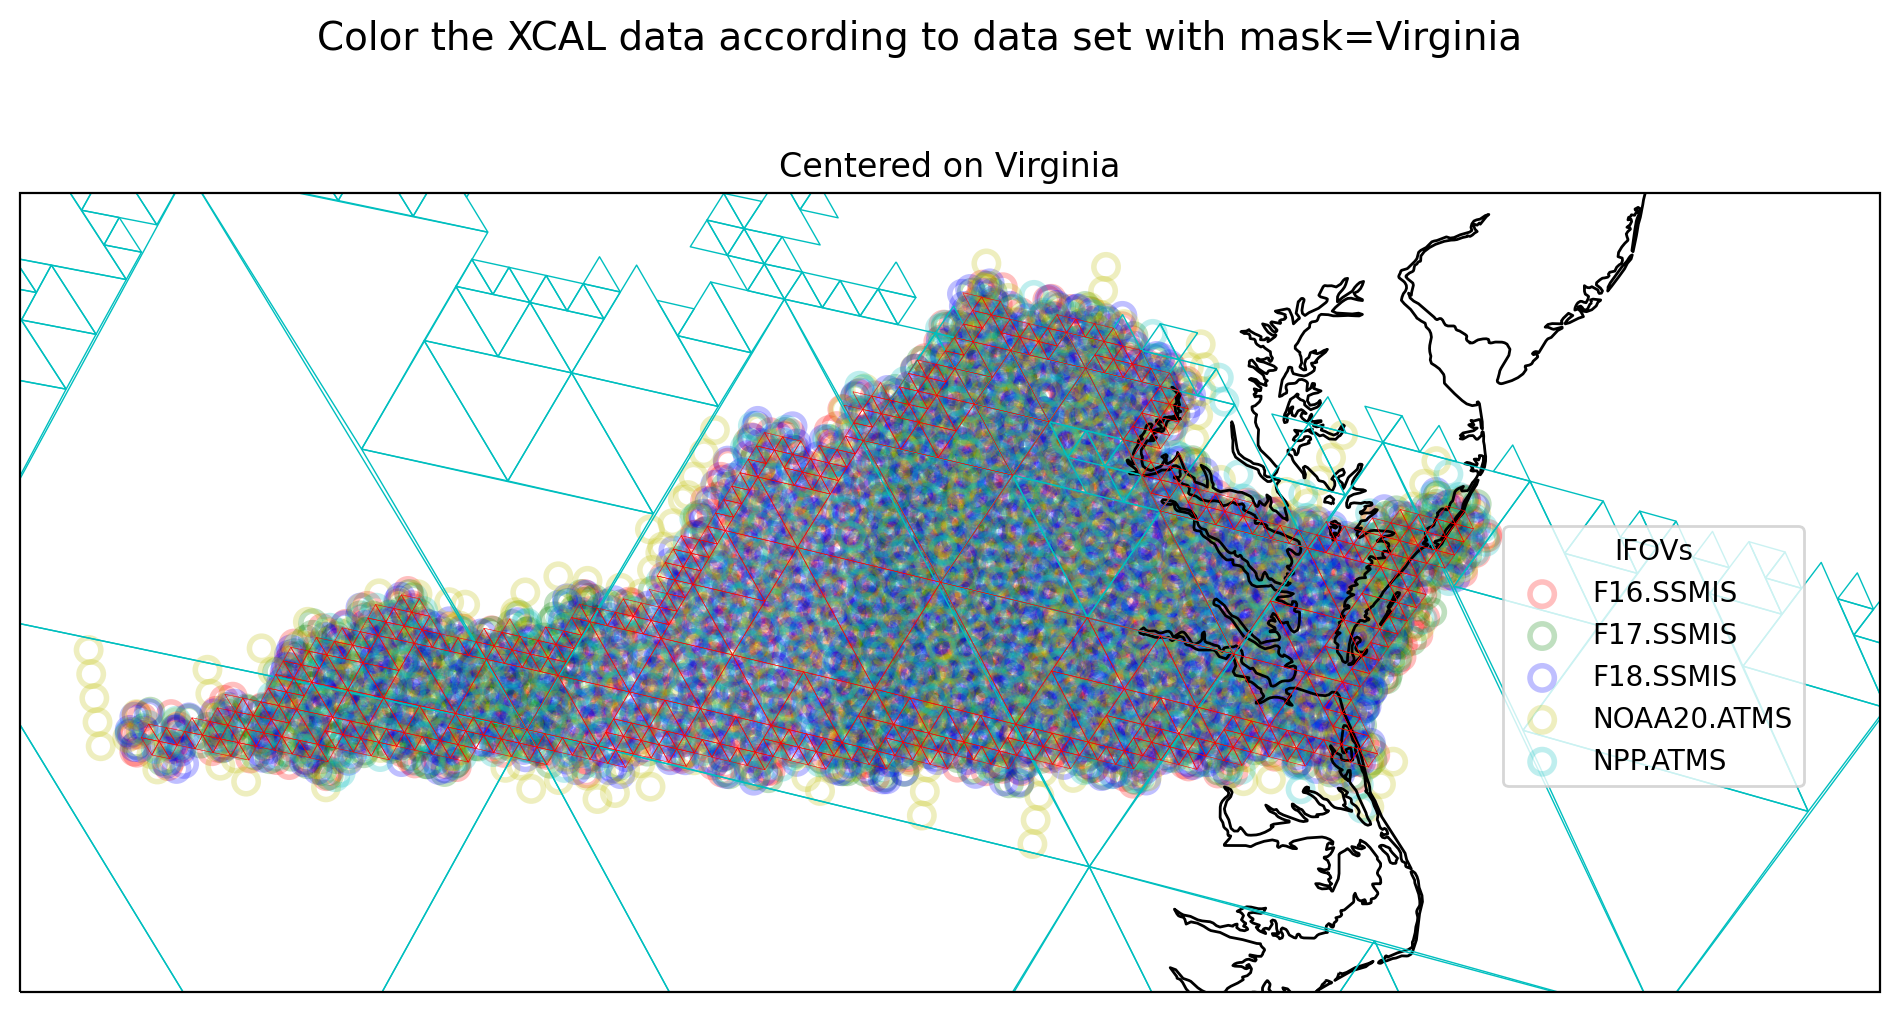

In [45]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax

if True:
    # Virginia
    extent = [-84.5, -72.5, 35, 40]
    lat0=37.5
    lon0=-77.5
    ax.set_extent(extent)
    delta=50
    marker_scale = 4*(12.0/(2*delta))
    extent_name  = 'Virginia'
    legend_anchor = (0.79,0.6)
    legend_marker_scale = 1

if False:
    # NASA Mid-Atlantic Regional Spaceport
    # geo:37.843333,-75.478056
    lat0=37.843333
    lon0=-75.478056
    delta=0.5
    extent = [lon0-delta, lon0+delta, lat0-delta, lat0+delta]
    ax.set_extent(extent)
    marker_scale = (12.0/(2*delta))
    extent_name  = 'NASA Mid-Atlantic Regional Spaceport'
    legend_anchor = (1.05,0.6)
    legend_marker_scale = 0.25
    
ax.coastlines()
ax.set_extent(extent)

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0: 
        s_.plot(ax=ax, trixels=False, lw=2, transform=transf, markersize=160*marker_scale, alpha=0.25, edgecolor=v, facecolor='none',label=k)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='c')
roi.plot(ax=ax, zorder=3, linewidth=0.2, color='r')

plt.legend(bbox_to_anchor=legend_anchor,markerscale=legend_marker_scale,title='IFOVs')

plt.suptitle('Color the XCAL data according to data set with mask=%s'%mask_name,fontsize=14)
plt.title('Centered on %s'%extent_name,fontsize=12)

plt.show()
del usr_figax,ax

In [46]:
timings.add('XCAL IFOV visualization',datetime.datetime.now()-start08)
timings.add('Total run time for XCAL load, subset, and visuals',datetime.datetime.now()-start04)
timings.add('Total run time',datetime.datetime.now()-start00)

XCAL IFOV visualization 0:00:01.919222
Total run time for XCAL load, subset, and visuals 0:01:27.788713
Total run time 0:02:53.632786


## Timing summary

In [47]:
print('Times in seconds')
timings.print_report(fmt="{:58}: {:>6.2f}")

Times in seconds
Load features                                             :  16.14
Construct ROI STARE cover                                 :  57.07
Select features intersecting ROI.                         :  12.16
Precip rate analysis                                      :   0.43
Total run time for IMERG statistics associated with ROI   :  85.82
Time-slices visualization                                 :   8.52
Calculate pod names                                       :   0.02
XCAL initial load                                         :  21.00
XCAL STARE prep (including viz prep)                      :  55.03
XCAL remask to ROI                                        :   1.29
XCAL IFOV visualization                                   :   1.92
Total run time for XCAL load, subset, and visuals         :  87.79
Total run time                                            : 173.63
